# Tutorials of PINNs Physical Informed Neural Network

This is the tutorial about the implementations of physical informed neural network for the SMU SML paper reading group.  
In the first section, the physical informed neural network is implemented based on numpy, with details about the implementations of backpropagations and the computations of residual.  
In the second section, the implementation is based on the pytorch package.  
All those implementations are run on my laptop. You could move those on to ManeFrame II. The last section relates to the enviroment settings on ManeFrame II in case you want to try V100/P100 GPUs on ManeFrame II.

### Section I: Implementations from scratch based on __Numpy__

In this section, we build the neural networks from scratch based on the numpy package with specific physical laws (PDEs & ODEs) as regularizations.  

This section is based on https://towardsdatascience.com/coding-a-neural-network-from-scratch-in-numpy-31f04e4d605, https://www.geeksforgeeks.org/implementation-of-neural-network-from-scratch-using-numpy/

Let's give a short review first.  

The feed forward neural network, or deep neural network is the mathematical model of neural connections in brain, with trainable weights and activation functions with bias that simulate the intensities of the connections between each neuron, or the concentrations of the neurotransmitters at the synapse between each neuron, and the activation with specific threshold of every neuron, respectively. (Biological terminologies are from https://www.inf.ed.ac.uk/teaching/courses/nlu/assets/reading/Gurney_et_al.pdf, this is a really nice book). Mathematically, The architecture of neural network with one neuron has form
$$
A = \sigma(\sum_i^n\omega_i*x_i + b),
$$
where $\omega_i, i=1\ldots n$ are the weights (the intensities of the connections between each neuron), and $\sigma$ is the activation function with threshold $b$. 

And the neurons could also be sumed with several trainable weights
$$
A = \sum_j^m W_j\sigma(\sum_i^n\omega_{ij}x_i + b_j)
$$
which is a layer of neurons. The neurons are called the hidden neurons, thus the layer may also be refered as hidden layers.

Thus, the deep neural network are the stack of several hidden layers,
$$
\tag{1}
A = \sum_j^m W_j\sigma(\ldots \sigma(\sum_i^n\omega_{i\cdot}x + b_\cdot)+ \ldots + b_j)
$$
where the $\cdot$ in the inner most layer means the index of the neurons in the next layer.
For the last layer, or the layer intermediate to the output, sometimes we get rid of the bias for that layer, as shown in Eq. (1). 

We could also write these architecture by matrix form
$$\tag{2}
A = \boldsymbol{W_n}\sigma(\ldots \sigma(\boldsymbol{W}_1 x + \boldsymbol{b}_1) +\ldots + \boldsymbol{b}_n)
$$
with $\boldsymbol{W}_n$ as the weight matricies and $\boldsymbol{b}_n$ as the bias vectors.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200522110034/NURELNETWORK.jpg" alt="drawing" width="600"/>

*The schematics of a 1 hidden layer neral network with 5 hidden neurons, 30 input dimentions, and 3 output dimensions. The weights $\boldsymbol{W}_1$ for the input $\boldsymbol{x}$ is a $30\times 5$ matrix. The bias vector $\boldsymbol{b}_1$ has shape $5\times 1$. The weights $\boldsymbol{W}_2$ for the output has shape $5\times 3$.*


Now, We build the neural networks by numpy from scratch to give an intuitive understanding about the backpropagations. To simplify the coding, we only implement the neural network with 1 hidden layer.

#### Activation Functions
First, we implement the activation function, the considered activation function is sigmoid(x)

$$
\sigma(x) = \dfrac{1}{1+e^{-x}}
$$

In [ ]:
import numpy as np
def sigmoid(x):
    return 1/(1 + np.exp(-x))

#### Creating the Feed forward neural network

Now we consider a 1 hidden layer neural network with 50 hidden neurons in the hidden layer.
- 1 Input layer (1)
- 1 hidden layer (50)
- 1 output layer (1)

In [ ]:
def f_forward(t, w1, b1, w2):
    # hidden
    z1 = t.dot(w1) + b1# input from layer 1
    a1 = sigmoid(z1)# out put of layer 2

    # Output layer
    a2 = a1.dot(w2)# input of out layer
    return a2

The problem we consider to solve is a first-order ode
$$ 
u^{\prime} = u, \;\;\; t \in [0,1],
$$
with initial condition $u(0) = 1$

Let $u_{\theta}$ be the neural network with parameters $\theta$ sovling the ode. Thus, the corresponding loss we considered has 2 part, the residual $\int_0^1 (u_{\theta}^{\prime} - u_{\theta})^2dt$ and the boundary loss $(u_{\theta}(0) - 1)^2$. The residual is approximated by 
$$
\int_0^1 (u_{\theta}^{\prime} - u_{\theta})^2 dt \approx \dfrac{1}{n}\sum_i (u_\theta^{\prime}(t_i) - u_\theta(t_i))^2
$$

In [ ]:
def loss(u, u_prime, u0):
    # Residual
    s =(np.square(u - u_prime))
    s = np.mean(s)
    # boundary loss
    s = s + np.square(u0-1.)
    return s

To compute the derivative $\dfrac{\partial }{\partial t} u_\theta$, we could first derive it by hand

$$
\begin{aligned}
\dfrac{\partial }{\partial t} u_\theta & = \dfrac{\partial }{\partial t} \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t + \boldsymbol{b}_1) \\
                                       & = \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}]
\end{aligned}
$$
with $\odot$ as the elementwise multiplications.

Note $\sigma^{\prime}(x) = \sigma(x)\cdot(1-\sigma(x))$

In [ ]:
def dudt(t, W1,b1,W2):
    # hidden layer
    z1 = t.dot(w1)+b1# input from layer 1
    a1 = sigmoid(z1)# output of hidden Layer
    InSquareBracket = np.multiply(np.multiply(a1, 1-a1), W1) # \sigma^{\prime}(W_1 x + b_1)\odot W_1
    u_t = InSquareBracket.dot(w2)
    return u_t   
    

Now we implement the backpropagation with respect to the parameters $\boldsymbol{W}_1, \boldsymbol{b}_1, \boldsymbol{W}_2$.

According to the loss, 

$$
\begin{aligned}
\mathcal{L}(\theta) &= (u_{\theta}(0) - 1)^2 + \dfrac{1}{n}\sum_i (  u_\theta^{\prime}(t_i) - u_\theta(t_i))^2
\end{aligned}
$$

To find the best opproximation, we consider to minimize the loss by gradient descent method. 

The derivative of loss $\mathcal{L}$ with respect to $\boldsymbol{W}_1, \boldsymbol{b}_1, \boldsymbol{W}_2$ should have form
$$
\begin{aligned}
\dfrac{\partial}{\partial \boldsymbol{W}_1} \mathcal{L}(\theta) &= \dfrac{\partial}{\partial \boldsymbol{W}_1}\left[ (\boldsymbol{W_2}\sigma(\boldsymbol{W}_1 0 + \boldsymbol{b}_1) - 1)^2 + \dfrac{1}{n}\sum_i (  \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1))^2\right]\\
& = \dfrac{1}{n}\sum_i 2 \left\{ \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\right\} \left\{ \boldsymbol{W_2}\odot[t_i \sigma^{\prime\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1} + \sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)] - \boldsymbol{W_2}\odot\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)t_i\right\}\\
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial}{\partial \boldsymbol{b}_1} \mathcal{L}(\theta) &= \dfrac{\partial}{\partial \boldsymbol{b}_1}\left[ (\boldsymbol{W_2}\sigma(\boldsymbol{W}_1 0 + \boldsymbol{b}_1) - 1)^2 + \dfrac{1}{n}\sum_i (  \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1))^2\right]\\
& = 2 (\boldsymbol{W_2}\sigma(\boldsymbol{b}_1) - 1)(\boldsymbol{W_2}\odot\sigma^{\prime}(\boldsymbol{b}_1)) + \dfrac{1}{n}\sum_i 2 \left\{  \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\right\} \left\{   \boldsymbol{W_2}\odot[ \sigma^{\prime\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}]  - \boldsymbol{W_2}\odot\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\right\}\\
\end{aligned}
$$

$$
\begin{aligned}
\dfrac{\partial}{\partial \boldsymbol{W}_2} \mathcal{L}(\theta) &= \dfrac{\partial}{\partial \boldsymbol{W}_2}\left[ (\boldsymbol{W_2}\sigma(\boldsymbol{W}_1 0 + \boldsymbol{b}_1) - 1)^2 + \dfrac{1}{n}\sum_i (  \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1))^2\right]\\
& = 2 (\boldsymbol{W_2}\sigma(\boldsymbol{b}_1) - 1)(\sigma^{}(\boldsymbol{b}_1)) + \dfrac{1}{n}\sum_i 2 \left\{  \boldsymbol{W_2}[\sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\sigma(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\right\} \left\{   [ \sigma^{\prime}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\odot \boldsymbol{W}_{1}]  - \sigma^{}(\boldsymbol{W}_1 t_i + \boldsymbol{b}_1)\right\}\\
\end{aligned}
$$

**I strongly recommend you to derive those derivatives!** 

Now by change of variables, 
   $$
    \begin{aligned}
        a_i &= \sigma \left( \boldsymbol{W}_{1} t_{i} + \boldsymbol{b}_{1} \right)\\
        \sigma^{\prime}\left( \boldsymbol{W}_{1}t_{i} + \boldsymbol{b}_{1} \right) &= a_{i}\odot\left( 1-a_{i} \right)\\
        \sigma^{\prime\prime}\left( \boldsymbol{W}_{1}t_{i} + \boldsymbol{b}_{1} \right) &= \left( 1-2a_{i} \right)\odot a_{i}\odot\left( 1-a_{i} \right)\\
     \end{aligned}
    $$
we could see the derivative more clearly.

$$
\dfrac{\partial}{\partial \boldsymbol{W}_1} \mathcal{L}(\theta) = \dfrac{1}{n} \sum_i 2 \left\{ \boldsymbol{W_2}\cdot[a_i\odot(1-a_i) \odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\cdot a_i\right\} \left\{ \boldsymbol{W_2}\odot[t_i\left( 1-2a_{i} \right)\odot a_{i}\odot\left( 1-a_{i} \right)\odot \boldsymbol{W}_{1} + a_{i}\odot\left( 1-a_{i} \right)] - \boldsymbol{W_2}\odot a_{i}\odot\left( 1-a_{i} \right)t_i\right\}
$$

$$
\dfrac{\partial}{\partial \boldsymbol{b}_1} \mathcal{L}(\theta) =  2 (\boldsymbol{W_2}\cdot\sigma(\boldsymbol{b}_1) - 1)\boldsymbol{W_2}\odot\sigma^{\prime}(\boldsymbol{b}_1) + \dfrac{1}{n}\sum_i 2 \left\{  \boldsymbol{W_2}\cdot[a_{i}\odot\left( 1-a_{i} \right)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\cdot a_i\right\} \left\{   \boldsymbol{W_2}\odot \left( 1-2a_{i} \right)\odot a_{i}\odot\left( 1-a_{i} \right)\odot \boldsymbol{W}_{1}  - \boldsymbol{W_2}\odot a_{i}\odot\left( 1-a_{i} \right)\right\}
$$

$$
\dfrac{\partial}{\partial \boldsymbol{W}_2} \mathcal{L}(\theta) = 2 (\boldsymbol{W_2}\cdot\sigma(\boldsymbol{b}_1) - 1)\sigma^{}(\boldsymbol{b}_1) + \dfrac{1}{n}\sum_i 2 \left\{  \boldsymbol{W_2}\cdot[a_{i}\odot\left( 1-a_{i} \right)\odot \boldsymbol{W}_{1}] - \boldsymbol{W_2}\cdot a_i\right\} \left\{   a_{i}\odot\left( 1-a_{i} \right)\odot \boldsymbol{W}_{1}  - a_i\right\}
$$


Furthermore, Let 
$$
    \begin{aligned}
        \boldsymbol{a} &= \sigma \left( \boldsymbol{W}_{1} \boldsymbol{t}+ \boldsymbol{b}_{1} \right)\\
        \boldsymbol{o} &= \boldsymbol{W}_{2}\cdot \boldsymbol{a}\\
        d_r&=  2 \boldsymbol{a}\odot \left( 1-\boldsymbol{a} \right) \odot \boldsymbol{W}_{1}\cdot \boldsymbol{W}_{2} - \boldsymbol{o}\\
        dd_r&= \boldsymbol{W}_{2}^{T}\odot W_1 \odot \left( 1- 2 \boldsymbol{a} \right) \odot \boldsymbol{a}\odot \left( 1-\boldsymbol{a} \right)\\
        w2_{dt} &= \boldsymbol{W}_{2}^{T}\odot \boldsymbol{a} \odot \left( 1-\boldsymbol{a} \right)
     \end{aligned}
$$

Note here $\boldsymbol{a}$ is a matrix with shape (batch_size, 50), so the elementwise multiplication of $\boldsymbol{a}$ with $\boldsymbol{W}$ should be understood as that $\boldsymbol{W}$ is broadcastting along the batch axis first ( from shape (1,50) -> (batch_size, 50)), then do the elementwise multiplication with $\boldsymbol{a}$.


__When implementing those structures, keep eyes on the shape of the inputs and outputs!__

In [ ]:

   
# Back propagation of error
def back_prop(t, t0, w1, b1, w2, alpha):
    # t  shape: batch_size x 1
    # W1 shape: 1 x 50
    # b1 shape: 1 x 50
    # W2 shape: 50 x 1
     
    # hidden layer
    z1 = t.dot(w1) + b1# input from layer 1: batch_size x 50
    a = sigmoid(z1)# output of layer 2: batch_size x 50
     
    # Output layer
    o = a.dot(w2)# input of out layer: batch_size x 1

    
    # Initial Condition
    z10 = t0.dot(w1) + b1
    a0 = sigmoid(z10)
    o0 = a0.dot(w2)
    
    
    # difference in the output layer from initial conditions
    d_i = 2*(o0 - 1) # shape 1 x 1
    
    # difference in the output layer from the residual
    d_r = 2*(np.multiply(np.multiply(a, 1-a), w1).dot(w2) - o) # shape: batch_size x 1
    dd_r = np.multiply(w2.transpose(), np.multiply(np.multiply(np.multiply(1- 2*a, a), 1 - a), w1)) # shape: batch_size x 50
    w2_dt = np.multiply(w2.transpose(), np.multiply(a, 1-a))
    dsigmab = np.multiply(sigmoid(b1), 1- sigmoid(b1))
    
    
    # Gradient for w1 and w2
    dL_dw1= np.mean( np.multiply(d_r, np.multiply(dd_r, t) + np.multiply(w2_dt, 1-t)) ,axis=0, keepdims=True)
    dL_db1= np.mean( np.multiply(d_r, dd_r - w2_dt), axis=0, keepdims=True) + d_i*np.multiply(w2.transpose(), dsigmab)
    dL_dw2= (np.mean(np.multiply(d_r, np.multiply(np.multiply(a, 1-a), w1) - a), axis=0, keepdims=True) + d_i*sigmoid(b1)).reshape(-1,1)
     
    # Updating parameters
    w1 = w1-(alpha*(dL_dw1))
    w2 = w2-(alpha*(dL_dw2))
    b1 = b1-(alpha*(dL_db1))


    return w1,b1,w2

Now we could implement the train function.

In [ ]:
def train(w1, b1, w2, alpha=0.01, epoch=100):
    losss = []
    t0 = np.zeros((1,1)) # Initial conditions
    # Let we assume the batch_size is 100, for every epoch, the neural network train 20 steps
    batch_size = 100
    steps = 40
    for j in range(epoch):
        l = []
        for i in range(steps):
            t = np.random.uniform(size=(batch_size,1)) # generate random t
            u = f_forward(t, w1, b1, w2)
            uprime = dudt(t, w1, b1, w2)
            u0 = f_forward(t0, w1, b1, w2) # initial conditions
            l.append(loss(u, uprime, u0))
            w1, b1, w2 = back_prop(t, t0, w1, b1, w2, alpha)
        print("epochs:", j + 1, "======== Loss:", ((sum(l)/len(l))))  
        losss.append(sum(l)/len(l))
    return losss, w1, b1, w2

Now we initialize the weights and bias

In [ ]:
# initializing the weights randomly
def generate_wt(x, y):
    l =[]
    for i in range(x * y):
        l.append(np.random.randn())
    return(np.array(l).reshape(x, y))


In [ ]:
w1 = generate_wt(1, 50)
b1 = generate_wt(1, 50)
w2 = generate_wt(50, 1)

In [ ]:
print(w1.shape)
print(w2.shape)
print(b1.shape)

In [ ]:
def pred(w1,b1, w2):
    t = np.linspace(0,1,100).reshape(100,1)
    out = f_forward(t, w1, b1, w2)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(t, np.exp(t), label='Exact')
    plt.plot(t, out,'--', label='pred')
    plt.legend()
    plt.show()
    plt.close()

train the model

In [ ]:
losss ,w1, b1, w2 = train(w1, b1, w2,alpha=0.02)

In [ ]:
pred(w1,b1,w2)

### Section II: Implementaions based on __Pytorch__
For this section, I assume you know how to install pyptorch and has some basic knowledge about python class & method & module.

In [1]:
import torch

Since the pytorch package has already packed the hidden layers we metioned above by `nn.linear`, we could build the neural network by `nn.Sequential`

In [25]:
model = torch.nn.Sequential(
        torch.nn.Linear(1,50),
        torch.nn.Sigmoid(),
        torch.nn.Linear(50,1, bias=False)
        )

Now we define the loss

In [28]:
def Loss(t, u0,t0):
    upred = model(t)
    # the u' is computed by torch.autograd.grad
    u_prime = torch.autograd.grad(upred, t, grad_outputs = torch.ones_like(t), retain_graph=True, create_graph=True)
    # Note the create_graph and retain_graph attributes are really important
    residual = torch.mean(torch.square(u_prime[0] - upred))
    u0pred = model(t0)
    init_loss = torch.mean(torch.square(u0pred - u0))
    return residual + 10*init_loss
    

Note for the pytorch package, we could compute the gradient by the `torch.autograd.grad` method. In this case, the `grad_outputs=` works as the vector in the jacobian vector product. 

Mathematically speaking, without setting `grad_outputs=`, the method `torch.autograd.grad` compute the jacobian of vector function $u_\theta(t0), u_\theta(t1), \ldots, u_\theta(t_n) $ with respect to each $t_i$

$$
\begin{bmatrix}
    \dfrac{\partial u_{\theta}\left( t_0 \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_0 \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{0} \right)}{\partial t_n}\\
    \dfrac{\partial u_{\theta}\left( t_1 \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_1 \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{1} \right)}{\partial t_n}\\
    \vdots & \vdots &\ddots & \vdots\\
    \dfrac{\partial u_{\theta}\left( t_n \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_n \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{n} \right)}{\partial t_n}
\end{bmatrix}
$$

Here, I did some simplifications of the notiation, to be more precisely, every partial derivative is the value 
$$
\dfrac{\partial u_{\theta}\left( t_i \right)}{\partial t_j} = \left.\dfrac{\partial u_{\theta}\left( t_i \right)}{\partial t_j}\right|_{t_i = t_i}
$$
i.e., the value of $\dfrac{\partial u_{\theta}\left( t_i \right)}{\partial t_j}$ at point $t_i$. 

So we may observe most of the components in the jacobian is $0$. By multiplying the `grad_outputs=torch.ones_like(t)` which is the gradient from the previous layer with respect to the input, shown as the vector on the right hand side, 
$$
\begin{bmatrix}
    \dfrac{\partial u_{\theta}\left( t_0 \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_0 \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{0} \right)}{\partial t_n}\\
    \dfrac{\partial u_{\theta}\left( t_1 \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_1 \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{1} \right)}{\partial t_n}\\
    \vdots & \vdots &\ddots & \vdots\\
    \dfrac{\partial u_{\theta}\left( t_n \right)}{\partial t_0} & \dfrac{\partial u_{\theta}\left( t_n \right)}{\partial t_1} & \ldots & \dfrac{\partial u_{\theta}\left( t_{n} \right)}{\partial t_n}
\end{bmatrix}
\cdot
\begin{bmatrix}
\dfrac{\partial t_0}{\partial t_0} \\
\dfrac{\partial t_1}{\partial t_1} \\
\vdots\\
\dfrac{\partial t_{n}}{\partial t_{n}}
\end{bmatrix}
$$
we could obtain the gradient from the outputs of the model to the inputs of the model. (Recall the **chain rule** here)

#### torch.autograd.grad

Note the `create_graph` & `retain_graph` attributes in the `torch.autograd.grad(upred, t, grad_outputs = torch.ones_like(t), retain_graph=True, create_graph=True)`, both of them need to be true. 
Plainly speaking, pytorch creates a dynamic graph when computing the gradients, which means it will be destroyed once the computation is finished. For the problems with PDE as loss, we need to compute the gradient of the outputs with respect to the input, the dynamic graph will be created during computation, once we obtain the gradients, the graph is destroyed. After this, every time you call `torch.autograd.grad(upred, t, grad_outputs = torch.ones_like(t), retain_graph=True, create_graph=True)`, pytorch will not create a graph. 

So, we need to retain the created graph for further computation like backpropagation with respect to the parameters, thus set `retain_graph=True`.

On the other hand, if the `create_graph` is false, the created graph will not be put into the dynamic computational graph of the neural network, which means the residual will not be back propagated to every parameters even though the residual is computed.

In the code block below, it is a very fast verification for the case with `create_graph=False`, `l.backward()` is the step that computing the gradients for each parameters. The computed gradients are stored in the `param.grad`.

In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.02)
t = torch.rand((batch_size,1))
t.requires_grad=True
upred = model(t)
u_prime = torch.autograd.grad(upred, t, grad_outputs = torch.ones_like(t), retain_graph=True)
l = torch.mean(u_prime[0])
optimizer.zero_grad()
l.backward()
print([param.grad for param in model.parameters()]

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

Note the runtimeError, since the graph of residual with respect to the parameters are not created, it reports the error that the parameter tensors does not require grad.

Now we could train our model, below gives the implementation of gradient descent we mentioned above, but we will use the `nn.optim` package to train the `model`

```python
def train(model,epochs):
    steps = 30
    batch_size = 100
    t0 = torch.zeros((1,1))
    u0 = torch.zeros((1,1))
    for j in range(epochs):
        for i in range(steps):
            t = torch.rand((batch_size,1))
            loss = Loss(model, t, u0, t0)
            
            # Zero the gradients before running the backward pass.
            model.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model. Internally, the parameters of each Module are stored
            # in Tensors with requires_grad=True, so this call will compute gradients for
            # all learnable parameters in the model.
            loss.backward()

            # Update the weights using gradient descent. Each parameter is a Tensor, so
            # we can access its gradients.
            with torch.no_grad():            
                for param in model.parameters():
                    param -= learning_rate * param.grad   

```

In [41]:
def train(epochs):
    epochs=50
    steps = 100
    batch_size = 100
    t0 = torch.zeros((1,1))
    u0 = torch.ones((1,1))
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.02)
    for j in range(epochs):
        L = []
        for i in range(steps):
            # since we need to compute the gradient with respec to t
            # we need to set the attribute requires_grad=True
            t = torch.rand((batch_size,1))
            t.requires_grad=True
            l = Loss(t, u0, t0)

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            L.append(l.item())
        print('Epoch:{}=====Loss:{}'.format(j + 1, sum(L)/len(L)))



In [39]:
def predict(model):
    t = torch.linspace(0, 1, 100).view((-1,1))
    pred = model(t)
    exact = torch.exp(t)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(t, exact, label='Exact')
    plt.plot(t, pred.detach().numpy(),'--', label='pred')
    plt.show()
    plt.close()

In [42]:
train(100)

Epoch:1=====Loss:0.004074094956740737
Epoch:2=====Loss:0.0038685844046995044
Epoch:3=====Loss:0.0039007688965648412
Epoch:4=====Loss:0.003718803892843425
Epoch:5=====Loss:0.003698199603240937
Epoch:6=====Loss:0.0035428230254910885
Epoch:7=====Loss:0.0034429417038336395
Epoch:8=====Loss:0.0034027533046901226
Epoch:9=====Loss:0.0033110639383085072
Epoch:10=====Loss:0.0032857614755630493
Epoch:11=====Loss:0.0032457706658169626
Epoch:12=====Loss:0.003125250298762694
Epoch:13=====Loss:0.0031054871040396394
Epoch:14=====Loss:0.0029810819355770945
Epoch:15=====Loss:0.0029422681347932664
Epoch:16=====Loss:0.002984375755768269
Epoch:17=====Loss:0.0029689159709960222
Epoch:18=====Loss:0.0028361188957933335
Epoch:19=====Loss:0.002828492691041902
Epoch:20=====Loss:0.0027768662804737686
Epoch:21=====Loss:0.002697467702673748
Epoch:22=====Loss:0.0026630342181306332
Epoch:23=====Loss:0.0025966416264418513
Epoch:24=====Loss:0.002580357356928289
Epoch:25=====Loss:0.0025786387792322784
Epoch:26=====Loss

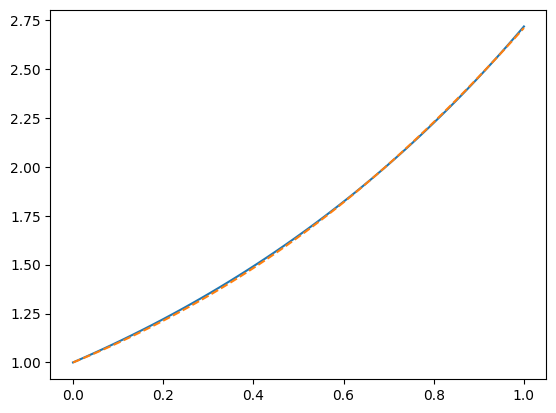

In [43]:
predict(model)

### Section III: Settings for the ManeFrame II

Built the following Conda environment

    module load spack

    module load gcc-9.2

    module load python/3

    module load cuda-11.4.2-gcc-9.2.0-nxqfgxj 

    module load cudnn-8.2.4.15-11.4-gcc-9.2.0-tfeuowy

 

    conda create --name **Env(Name of Environment)** numpy matplotlib jupyterlab(package you want) python=3.9(python version) --channel conda-forge

    conda activate Env

    pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
 

You’ll need to load the modules before you run everything. The cuda libraries are installed with spack, so loading spack makes them show up as available. Gcc is technically not necessary, but the default system compiler is pretty old and sometimes causes problem so I like to load a newer compiler. The python/3 module is to make a version of Conda available (you can install your own Miniconda or similar if you want more control.) Finally, cuda and cudnn are needed by tensorflow and Jax to use the GPUs (I believe these are the newest versions our current drivers will support).

 

If you are using the web portal, then you’ll want to put something like the following in the “Custom environment settings”

 

    module load spack

    module load gcc-9.2

    module load python/3

    module load cuda-11.4.2-gcc-9.2.0-nxqfgxj

    module load cudnn-8.2.4.15-11.4-gcc-9.2.0-tfeuowy

    eval "$(conda shell.bash hook)"

    conda activate Env

 

The “eval” line makes sure the conda commands are available and then the last line activates the conda environment build above (feel free to change the name to whatever you’d like.)
